In [1]:
import os

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
import tensorflow as tf

In [4]:
import tensorflow_datasets as tfds

In [5]:
import time
import numpy as np
import matplotlib.pyplot as plt

In [6]:
example, metadata = tfds.load("ted_hrlr_translate/pt_to_en", with_info=True, as_supervised=True)

In [7]:
train_examples, val_examples = example["train"], example["validation"]

In [8]:
dir(train_examples)

['_GeneratorState',
 '__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_cache',
 '_abc_negative_cache',
 '_abc_negative_cache_version',
 '_abc_registry',
 '_add_variable_with_custom_getter',
 '_apply_options',
 '_as_serialized_graph',
 '_buffer_size',
 '_checkpoint_dependencies',
 '_consumers',
 '_deferred_dependencies',
 '_flat_shapes',
 '_flat_structure',
 '_flat_types',
 '_functions',
 '_gather_saveables_for_checkpoint',
 '_graph',
 '_graph_attr',
 '_handle_deferred_dependencies',
 '_has_captured_ref',
 '_input_dataset',
 '_inputs',
 '_list_extra_dependencies_for_serialization',
 '_list_functions_for_serialization',
 '_lookup_d

In [9]:
train_examples.from_tensors

<function tensorflow.python.data.ops.dataset_ops.DatasetV2.from_tensors(tensors)>

In [10]:
tokenizer_en = tfds.features.text.SubwordTextEncoder.build_from_corpus((en.numpy() for pt, en in train_examples), target_vocab_size=2**13)

In [11]:
tokenizer_pt = tfds.features.text.SubwordTextEncoder.build_from_corpus((pt.numpy() for pt, en in train_examples), target_vocab_size=2**13)

In [12]:
sample_string = "Transformer is awesome."

tokenized_string = tokenizer_en.encode(sample_string)
print ('Tokenized string is {}'.format(tokenized_string))

Tokenized string is [7915, 1248, 7946, 7194, 13, 2799, 7877]


In [13]:
origin_string = tokenizer_en.decode(tokenized_string)
origin_string

'Transformer is awesome.'

In [14]:
assert sample_string == origin_string

In [15]:
for ts in tokenized_string:
    print("{} - - ->>> {}".format(ts, tokenizer_en.decode([ts])))

7915 - - ->>> T
1248 - - ->>> ran
7946 - - ->>> s
7194 - - ->>> former 
13 - - ->>> is 
2799 - - ->>> awesome
7877 - - ->>> .


In [16]:
dir(tokenizer_en)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_cache',
 '_abc_negative_cache',
 '_abc_negative_cache_version',
 '_abc_registry',
 '_build_from_token_counts',
 '_byte_encode',
 '_cache_size',
 '_filename',
 '_id_to_subword',
 '_init_from_list',
 '_max_subword_len',
 '_read_lines_from_file',
 '_subword_to_id',
 '_subwords',
 '_token_to_ids',
 '_token_to_ids_cache',
 '_token_to_subwords',
 '_tokenizer',
 '_write_lines_to_file',
 'build_from_corpus',
 'decode',
 'encode',
 'load_from_file',
 'save_to_file',
 'subwords',
 'vocab_size']

In [17]:
print("en vocab size:", tokenizer_en.vocab_size)
print("pt vocab size:", tokenizer_pt.vocab_size)

en vocab size: 8087
pt vocab size: 8214


In [18]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

In [19]:
def encode(lang1, lang2):
    lang1 = [tokenizer_pt.vocab_size] + tokenizer_pt.encode(lang1.numpy()) + [tokenizer_pt.vocab_size + 1]
    
    lang2 = [tokenizer_en.vocab_size] + tokenizer_en.encode(lang2.numpy()) + [tokenizer_en.vocab_size + 1]
    
    return lang1, lang2

In [20]:
MAX_LENGTH = 40

In [21]:
def filter_max_length(x, y, max_length=MAX_LENGTH):
    return tf.logical_and(tf.size(x) <= max_length, tf.size(y) <= max_length)

In [22]:
tf.logical_and(True, True)

<tf.Tensor: shape=(), dtype=bool, numpy=True>

In [23]:
def tf_encode(pt, en):
    result_pt, result_en = tf.py_function(encode, [pt, en], [tf.int64, tf.int64])
    result_pt.set_shape([None])
    result_en.set_shape([None])

    return result_pt, result_en

In [24]:
train_dataset = train_examples.map(tf_encode)

In [25]:
train_dataset

<MapDataset shapes: ((None,), (None,)), types: (tf.int64, tf.int64)>

In [26]:
train_dataset = train_dataset.filter(filter_max_length)

In [27]:
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(BUFFER_SIZE).padded_batch(BATCH_SIZE,padded_shapes=([-1], [-1]))

流水线技术 重叠训练的预处理和模型训练步骤。当加速器正在执行训练步骤 N 时，CPU 开始准备步骤 N + 1 的数据。这样做可以将步骤时间减少到模型训练与抽取转换数据二者所需的最大时间（而不是二者时间总和）。

没有流水线技术，CPU 和 GPU/TPU 大部分时间将处于闲置状态:

In [28]:
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [29]:
val_dataset = val_examples.map(tf_encode)
val_dataset = val_dataset.filter(filter_max_length).padded_batch(BATCH_SIZE,padded_shapes=([-1], [-1]))

In [30]:
pt_batch, en_batch = next(iter(val_dataset))

In [31]:
pt_batch, en_batch

(<tf.Tensor: shape=(64, 38), dtype=int64, numpy=
 array([[8214,  342, 3032, ...,    0,    0,    0],
        [8214,   95,  198, ...,    0,    0,    0],
        [8214, 4479, 7990, ...,    0,    0,    0],
        ...,
        [8214,  584,   12, ...,    0,    0,    0],
        [8214,   59, 1548, ...,    0,    0,    0],
        [8214,  118,   34, ...,    0,    0,    0]])>,
 <tf.Tensor: shape=(64, 40), dtype=int64, numpy=
 array([[8087,   98,   25, ...,    0,    0,    0],
        [8087,   12,   20, ...,    0,    0,    0],
        [8087,   12, 5453, ...,    0,    0,    0],
        ...,
        [8087,   18, 2059, ...,    0,    0,    0],
        [8087,   16, 1436, ...,    0,    0,    0],
        [8087,   15,   57, ...,    0,    0,    0]])>)

## 位置编码（Positional encoding）

因为该模型并不包括任何的循环（recurrence）或卷积，所以模型添加了位置编码，为模型提供一些关于单词在句子中相对位置的信息。

位置编码向量被加到嵌入（embedding）向量中。嵌入表示一个 d 维空间的标记，在 d 维空间中有着相似含义的标记会离彼此更近。但是，嵌入并没有对在一句话中的词的相对位置进行编码。因此，当加上位置编码后，词将基于*它们含义的相似度以及它们在句子中的位置*，在 d 维空间中离彼此更近。

参看 [位置编码](https://github.com/tensorflow/examples/blob/master/community/en/position_encoding.ipynb) 的 notebook 了解更多信息。计算位置编码的公式如下：

$$\Large{PE_{(pos, 2i)} = sin(pos / 10000^{2i / d_{model}})} $$
$$\Large{PE_{(pos, 2i+1)} = cos(pos / 10000^{2i / d_{model}})} $$

In [32]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    
    return pos * angle_rates

In [33]:
def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis], np.arange(d_model)[np.newaxis, :], d_model)

    # 将 sin 应用于数组中的偶数索引（indices）；2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # 将 cos 应用于数组中的奇数索引；2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

In [34]:
pos_encoding = positional_encoding(50, 512)
print (pos_encoding.shape)

(1, 50, 512)


In [35]:
pos_encoding[0]

<tf.Tensor: shape=(50, 512), dtype=float32, numpy=
array([[ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00, ...,
         1.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       [ 8.41470957e-01,  5.40302277e-01,  8.21856201e-01, ...,
         1.00000000e+00,  1.03663289e-04,  1.00000000e+00],
       [ 9.09297407e-01, -4.16146845e-01,  9.36414719e-01, ...,
         1.00000000e+00,  2.07326579e-04,  1.00000000e+00],
       ...,
       [ 1.23573124e-01, -9.92335498e-01,  9.77189839e-01, ...,
         9.99987245e-01,  4.87215538e-03,  9.99988139e-01],
       [-7.68254638e-01, -6.40144348e-01,  7.31235921e-01, ...,
         9.99986708e-01,  4.97581763e-03,  9.99987602e-01],
       [-9.53752637e-01,  3.00592542e-01, -1.44026920e-01, ...,
         9.99986112e-01,  5.07947942e-03,  9.99987125e-01]], dtype=float32)>

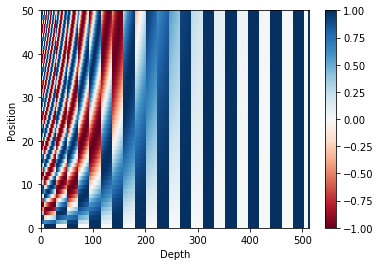

In [36]:
plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

## 遮挡（Masking）

遮挡一批序列中所有的填充标记（pad tokens）。这确保了模型不会将填充作为输入。该 mask 表明填充值 `0` 出现的位置：在这些位置 mask 输出 `1`，否则输出 `0`。

In [37]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    print("seq shape:", seq.shape)
    
    return seq[:, tf.newaxis, tf.newaxis, :]

In [38]:
tf.cast(tf.math.equal(1, 0), tf.float32)

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

In [39]:
x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])

In [40]:
create_padding_mask(x)

seq shape: (3, 5)


<tf.Tensor: shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

前瞻遮挡（look-ahead mask）用于遮挡一个序列中的后续标记（future tokens）。换句话说，该 mask 表明了不应该使用的条目。

这意味着要预测第三个词，将仅使用第一个和第二个词。与此类似，预测第四个词，仅使用第一个，第二个和第三个词，依此类推。

In [41]:
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    
    return mask

In [42]:
x = tf.random.uniform((1, 3))

In [43]:
x

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[0.401595  , 0.69534254, 0.4919672 ]], dtype=float32)>

In [44]:
tem = create_look_ahead_mask(x.shape[1])

In [45]:
tem

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

## 按比缩放的点积注意力（Scaled dot product attention）

<img src="https://tensorflow.google.cn/images/tutorials/transformer/scaled_attention.png" width="500" alt="scaled_dot_product_attention">

Transformer 使用的注意力函数有三个输入：Q（请求（query））、K（主键（key））、V（数值（value））。用于计算注意力权重的等式为：

$$\Large{Attention(Q, K, V) = softmax_k(\frac{QK^T}{\sqrt{d_k}}) V} $$

点积注意力被缩小了深度的平方根倍。这样做是因为对于较大的深度值，点积的大小会增大，从而推动 softmax 函数往仅有很小的梯度的方向靠拢，导致了一种很硬的（hard）softmax。

例如，假设 `Q` 和 `K` 的均值为0，方差为1。它们的矩阵乘积将有均值为0，方差为 `dk`。因此，*`dk` 的平方根*被用于缩放（而非其他数值），因为，`Q` 和 `K` 的矩阵乘积的均值本应该为 0，方差本应该为1，这样会获得一个更平缓的 softmax。

遮挡（mask）与 -1e9（接近于负无穷）相乘。这样做是因为遮挡与缩放的 Q 和 K 的矩阵乘积相加，并在 softmax 之前立即应用。目标是将这些单元归零，因为 softmax 的较大负数输入在输出中接近于零。

- query向量：query顾名思义，是负责寻找这个字的于其他字的相关度（通过其它字的key） 
- key向量：key向量就是用来于query向量作匹配，得到相关度评分的 
- value向量：Value vectors 是实际上的字的表示, 一旦我们得到了字的相关度评分，这些表示是用来加权求和的

得到每个字的  之后，我们要得到每个字和句子中其他字的相关关系，我们只需要把这个字的query去和其他字的key作匹配，然后得到分数，最后在通过其它字的value的加权求和（权重就是哪个分数）得到这个字的最终输出。

In [46]:
def scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = tf.matmul(q, k, transpose_b=True)
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
    
    # 将 mask 放入到缩放的张量上
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)
    
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
    
    output = tf.matmul(attention_weights, v)
    
    return output, attention_weights

In [47]:
-1e9

-1000000000.0

In [48]:
import numpy as np
def softmax(x):
    x= x - np.max(x)
    exp_x = np.exp(x)
    
    softmax_x = exp_x / np.sum(exp_x)
    return softmax_x

In [49]:
softmax([1, 2, 3, 4, 5*-1e9])

array([0.0320586 , 0.08714432, 0.23688282, 0.64391426, 0.        ])

In [50]:
5*-1e9

-5000000000.0

In [51]:
def print_out(q, k, v):
    temp_out, temp_attn = scaled_dot_product_attention(q, k, v, None)
    
    print("Attention weights are:")
    print(temp_attn)
    print("Output is:")
    print(temp_out)

In [52]:
np.set_printoptions(suppress=True)

temp_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[   1,0],
                      [  10,0],
                      [ 100,5],
                      [1000,6]], dtype=tf.float32)  # (4, 2)

# 这条 `请求（query）符合第二个`主键（key）`，
# 因此返回了第二个`数值（value）`。
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)

print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


## 多头注意力（Multi-head Attention）

<img src="https://tensorflow.google.cn/images/tutorials/transformer/multi_head_attention.png" width="500" alt="multi-head attention">


多头注意力由四部分组成：
*    线性层并分拆成多头。
*    按比缩放的点积注意力。
*    多头及联。
*    最后一层线性层。

每个多头注意力块有三个输入：Q（请求）、K（主键）、V（数值）。这些输入经过线性（Dense）层，并分拆成多头。 

将上面定义的 `scaled_dot_product_attention` 函数应用于每个头（进行了广播（broadcasted）以提高效率）。注意力这步必须使用一个恰当的 mask。然后将每个头的注意力输出连接起来（用`tf.transpose` 和 `tf.reshape`），并放入最后的 `Dense` 层。

Q、K、和 V 被拆分到了多个头，而非单个的注意力头，因为多头允许模型共同注意来自不同表示空间的不同位置的信息。在分拆后，每个头部的维度减少，因此总的计算成本与有着全部维度的单个注意力头相同。

In [54]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads 

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)
    
    def split_heads(self, x, batch_size):
        
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]
        
        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)
        
        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)
        
        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)
        
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
        
        output = self.dense(concat_attention)
        
        return output, attention_weights

创建一个 `MultiHeadAttention` 层进行尝试。在序列中的每个位置 `y`，`MultiHeadAttention` 在序列中的所有其他位置运行所有8个注意力头，在每个位置y，返回一个新的同样长度的向量。

In [55]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)

In [56]:
y = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model)

In [57]:
y.shape

TensorShape([1, 60, 512])

In [58]:
out, attn = temp_mha(y, k=y, q=y, mask=None)

In [59]:
out.shape

TensorShape([1, 60, 512])

In [60]:
attn.shape

TensorShape([1, 8, 60, 60])

## 点式前馈网络（Point wise feed forward network）

点式前馈网络由两层全联接层组成，两层之间有一个 ReLU 激活函数。

In [61]:
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation="relu"),
        tf.keras.layers.Dense(d_model)
    ])

In [63]:
sample_ffn = point_wise_feed_forward_network(512, 2048)
sample_ffn(tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 512])

### 编码器（Encoder）

`编码器` 包括：
1.   输入嵌入（Input Embedding）
2.   位置编码（Positional Encoding）
3.   N 个编码器层（encoder layers）

输入经过嵌入（embedding）后，该嵌入与位置编码相加。该加法结果的输出是编码器层的输入。编码器的输出是解码器的输入。

<img src="https://tensorflow.google.cn/images/tutorials/transformer/transformer.png" width="600" alt="transformer">

In [71]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()
        
        self.d_model = d_model
        self.num_layers = num_layers
        
        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, self.d_model)
        
        self.enc_layers = [Encoder(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        
        self.dropout = tf.keras.layers.Dropout(rate)
        
    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]
        
        x = self.embedding(x)
        
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)

        return x  # (batch_size, input_seq_len, d_model)

In [72]:
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8, dff=2048, input_vocab_size=8500, maximum_position_encoding=10000)

TypeError: __init__() missing 2 required positional arguments: 'input_vocab_size' and 'maximum_position_encoding'